In [1]:
! hdfs dfs -ls /labs/slaba04/

Found 1 items
-rw-r--r--   3 hdfs hdfs  655090069 2021-02-27 22:13 /labs/slaba04/gender_age_dataset.txt


In [108]:
! hdfs dfs -ls

Found 4 items
drwx------   - alexander.kuznetsov alexander.kuznetsov          0 2021-03-25 11:37 .Trash
drwxr-xr-x   - alexander.kuznetsov alexander.kuznetsov          0 2021-03-25 11:08 .sparkStaging
drwxr-xr-x   - alexander.kuznetsov alexander.kuznetsov          0 2021-03-16 21:20 lab03.csv
drwxr-xr-x   - alexander.kuznetsov alexander.kuznetsov          0 2021-03-25 11:20 lab04_KAV.pkl


In [153]:
! hdfs dfs -rm -r lab04_KAV_lr.pkl

21/03/25 12:28:57 INFO fs.TrashPolicyDefault: Moved: 'hdfs://spark-de-master-1.newprolab.com:8020/user/alexander.kuznetsov/lab04_KAV_lr.pkl' to trash at: hdfs://spark-de-master-1.newprolab.com:8020/user/alexander.kuznetsov/.Trash/Current/user/alexander.kuznetsov/lab04_KAV_lr.pkl1616664537435


In [2]:
import os
import sys
os.environ["PYSPARK_PYTHON"]='/opt/anaconda/envs/bd9/bin/python'
os.environ["SPARK_HOME"]='/usr/hdp/current/spark2-client'
os.environ["PYSPARK_SUBMIT_ARGS"]='--num-executors 3 pyspark-shell'

spark_home = os.environ.get('SPARK_HOME', None)

sys.path.insert(0, os.path.join(spark_home, 'python'))
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.10.7-src.zip'))

In [3]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

conf = SparkConf()
conf.set("spark.app.name", "KuznetsovA GenderAgePrediction app") 

spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [4]:
spark

In [5]:
sc = spark.sparkContext

In [6]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, TimestampType, ArrayType, FloatType
import pyspark.sql.functions as f

In [7]:
from itertools import product

In [8]:
labels = list(product(("F", "M"), ("18-24", "25-34", "35-44", "45-54", ">=55")))
labels_schema = StructType(fields=[
    StructField("target_str", StringType()), 
    StructField("target_ind", IntegerType()),
])
labels_df = spark.createDataFrame([tuple(["{}|{}".format(x[0], x[1]), i]) for i, x in enumerate(labels)], schema=labels_schema)
labels_df.cache()
labels_df.show()

+----------+----------+
|target_str|target_ind|
+----------+----------+
|   F|18-24|         0|
|   F|25-34|         1|
|   F|35-44|         2|
|   F|45-54|         3|
|    F|>=55|         4|
|   M|18-24|         5|
|   M|25-34|         6|
|   M|35-44|         7|
|   M|45-54|         8|
|    M|>=55|         9|
+----------+----------+



In [9]:
labels_df.rdd.getNumPartitions()

3

In [10]:
schema = StructType(fields=[
    StructField("gender", StringType()),
    StructField("age", StringType()),
    StructField("uid", StringType()),
    StructField("user_json", StringType()),
])

In [11]:
json_schema = StructType(
                    fields=[
                        StructField("visits", 
                                    ArrayType(
                                        StructType(
                                            fields=[
                                                StructField("url", StringType()), 
                                                StructField("timestamp", StringType())
                                            ]
                                        )
                                    )
                        )
                    ]
)

In [12]:
df = (spark
      .read
      .schema(schema)
      .format("csv")
      .option("sep", "\t")
      .option("header", True)
      .load("/labs/slaba04/gender_age_dataset.txt"))

In [13]:
df.show()

+------+-----+--------------------+--------------------+
|gender|  age|                 uid|           user_json|
+------+-----+--------------------+--------------------+
|     F|18-24|d50192e5-c44e-4ae...|{"visits": [{"url...|
|     M|25-34|d502331d-621e-472...|{"visits": [{"url...|
|     F|25-34|d50237ea-747e-48a...|{"visits": [{"url...|
|     F|25-34|d502f29f-d57a-46b...|{"visits": [{"url...|
|     M| >=55|d503c3b2-a0c2-4f4...|{"visits": [{"url...|
|     F|25-34|d5090ddf-5648-487...|{"visits": [{"url...|
|     F|25-34|d50bcef8-16ff-4e8...|{"visits": [{"url...|
|     F|18-24|d50e23dc-0cbd-488...|{"visits": [{"url...|
|     F|45-54|d50fdabb-4208-441...|{"visits": [{"url...|
|     F|18-24|d511b480-23a6-482...|{"visits": [{"url...|
|     F|25-34|d51294ed-1b95-4e4...|{"visits": [{"url...|
|     F|25-34|d512e295-6a85-491...|{"visits": [{"url...|
|     M|25-34|d51441ea-9dda-454...|{"visits": [{"url...|
|     F|25-34|d51822d4-105b-457...|{"visits": [{"url...|
|     F|35-44|d5183db2-c8e5-413

In [14]:
df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- uid: string (nullable = true)
 |-- user_json: string (nullable = true)



In [15]:
visits = (df
          .filter(f.col("gender").isin(["F", "M"]))
          .filter(f.col("age").isin(["18-24", "25-34", "35-44", "45-54", ">=55"]))
          .withColumn("target_str", f.concat(f.col("gender"), f.lit("|"), f.col("age")))
          .join(f.broadcast(labels_df), on="target_str", how="left")
          .withColumn("user_json_parsed", f.from_json(f.col("user_json"), json_schema))
          .drop("user_json")
         )

In [16]:
visits.show(3, vertical=True, truncate=False)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [17]:
from pyspark.ml.feature import OneHotEncoderEstimator

In [18]:
target_oh_encoder = OneHotEncoderEstimator(inputCols=["target_ind"],
                                           outputCols=["target"], handleInvalid="keep")

In [19]:
target_model = target_oh_encoder.fit(visits)
visits2 = target_model.transform(visits)

In [20]:
visits2.show(5)

+----------+------+-----+--------------------+----------+--------------------+--------------+
|target_str|gender|  age|                 uid|target_ind|    user_json_parsed|        target|
+----------+------+-----+--------------------+----------+--------------------+--------------+
|   F|18-24|     F|18-24|d50192e5-c44e-4ae...|         0|[[[http://zebra-z...|(10,[0],[1.0])|
|   M|25-34|     M|25-34|d502331d-621e-472...|         6|[[[http://sweetra...|(10,[6],[1.0])|
|   F|25-34|     F|25-34|d50237ea-747e-48a...|         1|[[[http://ru.orif...|(10,[1],[1.0])|
|   F|25-34|     F|25-34|d502f29f-d57a-46b...|         1|[[[http://transla...|(10,[1],[1.0])|
|    M|>=55|     M| >=55|d503c3b2-a0c2-4f4...|         9|[[[https://mail.r...|(10,[9],[1.0])|
+----------+------+-----+--------------------+----------+--------------------+--------------+
only showing top 5 rows



In [21]:
visits2.select("target_str", "target_ind").groupBy("target_str", "target_ind").count().show()

+----------+----------+-----+
|target_str|target_ind|count|
+----------+----------+-----+
|   M|35-44|         7| 5089|
|   F|45-54|         3| 2597|
|   M|25-34|         6| 8666|
|   M|45-54|         8| 2147|
|   F|35-44|         2| 4271|
|   F|18-24|         0| 2886|
|   M|18-24|         5| 2012|
|   F|25-34|         1| 6791|
|    F|>=55|         4|  895|
|    M|>=55|         9|  784|
+----------+----------+-----+



In [22]:
visits2.count()

36138

In [23]:
8666 / 36138

0.23980297747523383

In [24]:
train_uid = visits2.sampleBy("target_ind", fractions={i: 0.8 for i in range(10)}, seed=5757).select("uid")
test_uid = visits2.join(train_uid, on="uid", how="leftanti").select("uid")

In [25]:
visits_exploded = (visits2
                   .select("gender", 
                           "age", 
                           "uid", 
                           "target_str",
                           "target_ind",
                           "target",
                           f.explode_outer(f.col("user_json_parsed").getItem("visits")).alias("user_visits"))
                   )

In [26]:
visits_exploded.show(5, vertical=True, truncate=False)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 gender      | F                                                                                                                                                                        
 age         | 18-24                                                                                                                                                                    
 uid         | d50192e5-c44e-4ae8-ae7a-7cfe67c8b777                                                                                                                                     
 target_str  | F|18-24                                                                                                                                                                  
 target_ind  | 0                                                           

In [27]:
visits_exploded.printSchema()

root
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- uid: string (nullable = true)
 |-- target_str: string (nullable = true)
 |-- target_ind: integer (nullable = true)
 |-- target: vector (nullable = true)
 |-- user_visits: struct (nullable = true)
 |    |-- url: string (nullable = true)
 |    |-- timestamp: string (nullable = true)



In [28]:
visits_exploded.select("target_str").groupBy("target_str").count().show()

+----------+-------+
|target_str|  count|
+----------+-------+
|    M|>=55| 161226|
|   M|25-34|1394530|
|   F|45-54| 338693|
|   M|18-24| 272569|
|   F|35-44| 629093|
|   M|35-44|1074861|
|   F|18-24| 213964|
|    F|>=55| 106715|
|   F|25-34| 662515|
|   M|45-54| 458786|
+----------+-------+



In [29]:
visits_exploded.count()

5312952

In [30]:
1394530 / 5312952

0.2624774325083306

In [31]:
from urllib.parse import urlparse

In [32]:
def _extract_domain(url):
    return urlparse(url).netloc

In [33]:
@f.pandas_udf(StringType())
def extract_domain(urls):
    return urls.apply(_extract_domain)

In [34]:
visits_exploded2 = (visits_exploded
 .withColumn("url", f.regexp_replace(f.regexp_replace(f.regexp_replace(
     f.col("user_visits").getItem("url"), 
     "http://https://", "https://"), "http://http://", "http://"), "http://&referrer=http://", "http://"))
 .withColumn("url_domain", extract_domain(f.col("url")))
 .withColumn("url_domain_splitted", f.split(f.col("url_domain"), "\."))
 .withColumn("url_country_domain", f.col("url_domain_splitted").getItem(f.size(f.col("url_domain_splitted")) - 1))
 .withColumn("timestamp", f.col("user_visits").getItem("timestamp"))
 .withColumn("dt", f.from_unixtime(f.col("timestamp") / 1000, "yyyy-MM-dd HH:mm:ss"))
 .withColumn("dt_hour", f.hour(f.col("dt")))
 .withColumn("dt_dayofweek", f.dayofweek(f.col("dt")))
 .withColumn("url_domain_array", f.array(f.col("url_domain")))
 .withColumn("url_country_domain_array", f.array(f.col("url_country_domain")))
 .drop("user_visits")
)

In [35]:
visits_exploded2.printSchema()

root
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- uid: string (nullable = true)
 |-- target_str: string (nullable = true)
 |-- target_ind: integer (nullable = true)
 |-- target: vector (nullable = true)
 |-- url: string (nullable = true)
 |-- url_domain: string (nullable = true)
 |-- url_domain_splitted: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- url_country_domain: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- dt: string (nullable = true)
 |-- dt_hour: integer (nullable = true)
 |-- dt_dayofweek: integer (nullable = true)
 |-- url_domain_array: array (nullable = false)
 |    |-- element: string (containsNull = true)
 |-- url_country_domain_array: array (nullable = false)
 |    |-- element: string (containsNull = true)



In [36]:
visits_exploded2.show(5, vertical=True, truncate=False)

-RECORD 0---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 gender                   | F                                                                                                                                                       
 age                      | 18-24                                                                                                                                                   
 uid                      | d50192e5-c44e-4ae8-ae7a-7cfe67c8b777                                                                                                                    
 target_str               | F|18-24                                                                                                                                                 
 target_ind               | 0                                                                  

In [37]:
visits_exploded2.cache()

DataFrame[gender: string, age: string, uid: string, target_str: string, target_ind: int, target: vector, url: string, url_domain: string, url_domain_splitted: array<string>, url_country_domain: string, timestamp: string, dt: string, dt_hour: int, dt_dayofweek: int, url_domain_array: array<string>, url_country_domain_array: array<string>]

In [38]:
visits_exploded2.select("url_domain").distinct().count(), visits_exploded2.select("url_country_domain").distinct().count()

(118746, 286)

In [39]:
visits_exploded2.select("url_domain").groupBy("url_domain").count().orderBy(f.desc("count")).show(50)

+--------------------+------+
|          url_domain| count|
+--------------------+------+
|        www.avito.ru|435586|
|          smotri.com|187242|
|       www.24open.ru| 83111|
|       loveplanet.ru| 82426|
|     www.youtube.com| 75522|
|     mail.rambler.ru| 73542|
|              vk.com| 72072|
|           yandex.ru| 64389|
|        www.ebay.com| 52524|
|           yabadu.ru| 44236|
|    www.yaplakal.com| 43552|
|        b.kavanga.ru| 34397|
|         topface.com| 33884|
|         www.ozon.ru| 33790|
|     www.svyaznoy.ru| 32935|
|  forum.littleone.ru| 32614|
|   go.youlamedia.com| 32102|
|        seasonvar.ru| 31181|
|         flirchi.com| 26037|
|         mail.qip.ru| 25893|
|         www.adme.ru| 25733|
|       www.sports.ru| 24861|
|          go.mail.ru| 24826|
|               vz.ru| 24705|
|     www.echo.msk.ru| 23809|
|    news.sportbox.ru| 23444|
|content.adspynet.com| 22875|
|              999.md| 22079|
|         pass.rzd.ru| 21957|
|          flirchi.ru| 20852|
|     www.

In [40]:
visits_exploded2.select("url_country_domain").groupBy("url_country_domain").count().orderBy(f.desc("count")).show(50)

+------------------+-------+
|url_country_domain|  count|
+------------------+-------+
|                ru|3417562|
|               com|1125783|
|               net| 199146|
|                ua|  95120|
|               org|  65464|
|                tv|  57260|
|                su|  46299|
|              info|  39130|
|                me|  38652|
|                md|  32678|
|                fm|  23024|
|                by|  21809|
|          xn--p1ai|  20889|
|                az|  18380|
|                kz|  13794|
|                cc|  12816|
|                de|   9131|
|               biz|   7617|
|                ws|   6651|
|                sg|   6297|
|               pro|   4726|
|                in|   3754|
|                uk|   3317|
|                tr|   3191|
|                am|   2650|
|                uz|   1844|
|                kg|   1811|
|                to|   1750|
|                lv|   1693|
|              name|   1593|
|                co|   1569|
|             

In [41]:
visits_exploded2.filter(f.col("url_country_domain") == "xn--p1ai").show(5, vertical=True, truncate=False)

-RECORD 0----------------------------------------------------------------------------------
 gender                   | M                                                              
 age                      | 25-34                                                          
 uid                      | d5241eeb-e364-4bac-9601-ac659d8fa865                           
 target_str               | M|25-34                                                        
 target_ind               | 6                                                              
 target                   | (10,[6],[1.0])                                                 
 url                      | http://www.xn----ctbbhcbd9a8acccjsf5d6a9h.xn--p1ai/news        
 url_domain               | www.xn----ctbbhcbd9a8acccjsf5d6a9h.xn--p1ai                    
 url_domain_splitted      | [www, xn----ctbbhcbd9a8acccjsf5d6a9h, xn--p1ai]                
 url_country_domain       | xn--p1ai                                            

In [42]:
import matplotlib.pyplot as plt

In [43]:
dt_hour_df = visits_exploded2.groupBy("dt_hour").count().toPandas()

In [44]:
dt_hour_df.head()

,dt_hour,count
0,12,271905
1,22,313480
2,1,126669
3,13,289155
4,16,307726


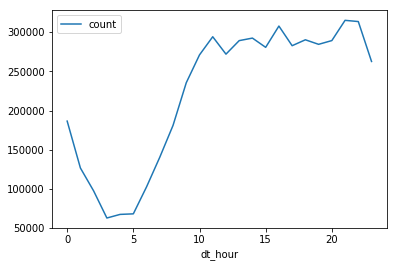

In [45]:
dt_hour_df.sort_values("dt_hour").set_index("dt_hour").plot()
plt.show()

In [46]:
dt_dayofweek_df = visits_exploded2.groupBy("dt_dayofweek").count().toPandas()

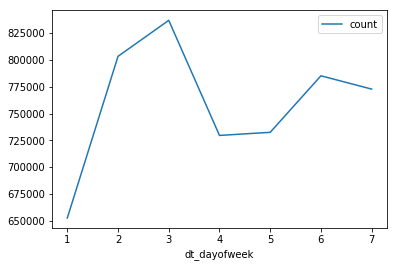

In [47]:
dt_dayofweek_df.sort_values("dt_dayofweek").set_index("dt_dayofweek").plot()
plt.show()

In [48]:
from pyspark.ml.linalg import VectorUDT, Vectors
from pyspark.ml.feature import HashingTF, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [49]:
feature_dayofweek_oh_encoder = OneHotEncoderEstimator(inputCols=["dt_dayofweek"],
                                                      outputCols=["dt_dayofweek_oh_vector"])
feature_hour_oh_encoder = OneHotEncoderEstimator(inputCols=["dt_hour"],
                                                 outputCols=["dt_hour_oh_vector"])
feature_urlcountrydomain_hasher = HashingTF(numFeatures=200, 
                                            inputCol="url_country_domain_array",
                                            outputCol="url_country_domain_vector")
feature_urldomain_hasher = HashingTF(numFeatures=1000, 
                                     inputCol="url_domain_array", 
                                     outputCol="url_domain_vector")
features_assembler = VectorAssembler(inputCols=["dt_dayofweek_oh_vector", 
                                       "dt_hour_oh_vector", 
                                       "url_country_domain_vector", 
                                       "url_domain_vector"], outputCol="features")

In [50]:
pipeline = Pipeline(stages=[
    feature_dayofweek_oh_encoder,
    feature_hour_oh_encoder,
    feature_urlcountrydomain_hasher,
    feature_urldomain_hasher,
    features_assembler,
])

In [51]:
train = visits_exploded2.join(train_uid, on="uid", how="inner")
test = visits_exploded2.join(test_uid, on="uid", how="inner")

In [52]:
model = pipeline.fit(train)
train_encoded = model.transform(train)
train_encoded.show(5, vertical=True)

-RECORD 0-----------------------------------------
 uid                       | 0392f398-ea7e-4a1... 
 gender                    | F                    
 age                       | >=55                 
 target_str                | F|>=55               
 target_ind                | 4                    
 target                    | (10,[4],[1.0])       
 url                       | http://www.adme.r... 
 url_domain                | www.adme.ru          
 url_domain_splitted       | [www, adme, ru]      
 url_country_domain        | ru                   
 timestamp                 | 1417907710000        
 dt                        | 2014-12-07 02:15:10  
 dt_hour                   | 2                    
 dt_dayofweek              | 1                    
 url_domain_array          | [www.adme.ru]        
 url_country_domain_array  | [ru]                 
 dt_dayofweek_oh_vector    | (7,[1],[1.0])        
 dt_hour_oh_vector         | (23,[2],[1.0])       
 url_country_domain_vector | (2

In [53]:
test_encoded = model.transform(test)
test_encoded.show(5, vertical=True)

-RECORD 0-----------------------------------------
 uid                       | 095544a2-64f7-422... 
 gender                    | F                    
 age                       | 25-34                
 target_str                | F|25-34              
 target_ind                | 1                    
 target                    | (10,[1],[1.0])       
 url                       | http://well-good.... 
 url_domain                | well-good.ru         
 url_domain_splitted       | [well-good, ru]      
 url_country_domain        | ru                   
 timestamp                 | 1417853994163        
 dt                        | 2014-12-06 11:19:54  
 dt_hour                   | 11                   
 dt_dayofweek              | 7                    
 url_domain_array          | [well-good.ru]       
 url_country_domain_array  | [ru]                 
 dt_dayofweek_oh_vector    | (7,[],[])            
 dt_hour_oh_vector         | (23,[11],[1.0])      
 url_country_domain_vector | (2

In [55]:
model.save("lab04_KAV.pkl")

In [56]:
from pyspark.ml.stat import Summarizer

In [147]:
train_encoded_grouped = (
    train_encoded
    .select("uid", "target_ind", "features")
    .groupBy("uid", "target_ind")
    .agg(
        Summarizer.mean(f.col("features")).alias("features_avged"),
#         f.count(f.col("features")).alias("count")
    )
)
test_encoded_grouped = (
    test_encoded
    .select("uid", "target_ind", "features")
    .groupBy("uid", "target_ind")
    .agg(
        Summarizer.mean(f.col("features")).alias("features_avged"),
#         f.count(f.col("features")).alias("count")
    )
)

In [148]:
train_encoded_grouped.show(5, vertical=True)

-RECORD 0------------------------------
 uid            | 0392f398-ea7e-4a1... 
 target_ind     | 4                    
 features_avged | [0.0,0.1650943396... 
-RECORD 1------------------------------
 uid            | 094b1e7e-97a6-441... 
 target_ind     | 0                    
 features_avged | [0.0,0.0,0.0,0.0,... 
-RECORD 2------------------------------
 uid            | 098a0e00-8597-475... 
 target_ind     | 4                    
 features_avged | [0.0,0.0,0.0,1.0,... 
-RECORD 3------------------------------
 uid            | 0a595fa1-bae0-41d... 
 target_ind     | 9                    
 features_avged | [0.0,0.1428571428... 
-RECORD 4------------------------------
 uid            | 0a6868f4-2cda-425... 
 target_ind     | 0                    
 features_avged | [0.0,0.0933333333... 
only showing top 5 rows



In [59]:
# features_agged_assembler = VectorAssembler(inputCols=["features_avged", "count"], outputCol="features_agged")

In [60]:
# train_grouped = features_agged_assembler.transform(train_encoded_grouped).drop("features_avged", "count")
# test_grouped = features_agged_assembler.transform(test_encoded_grouped).drop("features_avged", "count")

In [149]:
train_grouped = train_encoded_grouped.withColumn("features_agged", f.col("features_avged")).drop("features_avged")
test_grouped = test_encoded_grouped.withColumn("features_agged", f.col("features_avged")).drop("features_avged")

In [150]:
test_grouped.show(5, vertical=True)

-RECORD 0------------------------------
 uid            | 095544a2-64f7-422... 
 target_ind     | 1                    
 features_agged | [0.0,0.0,0.0,0.0,... 
-RECORD 1------------------------------
 uid            | 0b4db476-388d-43b... 
 target_ind     | 7                    
 features_agged | [0.0,0.0,0.0,0.0,... 
-RECORD 2------------------------------
 uid            | 1155961f-7ce1-453... 
 target_ind     | 2                    
 features_agged | [0.0,0.0,0.0,0.66... 
-RECORD 3------------------------------
 uid            | 27a93e75-1d90-41d... 
 target_ind     | 2                    
 features_agged | [0.0,0.0,0.131428... 
-RECORD 4------------------------------
 uid            | 2bead41b-eebc-43d... 
 target_ind     | 2                    
 features_agged | [0.0,0.0,0.0,0.0,... 
only showing top 5 rows



In [151]:
lr = LogisticRegression(featuresCol="features_agged", labelCol="target_ind", maxIter=20, regParam=0.1)

In [152]:
lr_model = lr.fit(train_grouped)

In [154]:
lr_model.save("lab04_KAV_lr.pkl")

In [155]:
train_predictions = lr_model.transform(train_grouped)

In [156]:
test_predictions = lr_model.transform(test_grouped)

In [157]:
test_predictions.printSchema()

root
 |-- uid: string (nullable = true)
 |-- target_ind: integer (nullable = true)
 |-- features_agged: vector (nullable = false)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [158]:
test_predictions.show(5, vertical=True)

-RECORD 0------------------------------
 uid            | 095544a2-64f7-422... 
 target_ind     | 1                    
 features_agged | [0.0,0.0,0.0,0.0,... 
 rawPrediction  | [-0.2861594023462... 
 probability    | [0.05672092375750... 
 prediction     | 6.0                  
-RECORD 1------------------------------
 uid            | 0b4db476-388d-43b... 
 target_ind     | 7                    
 features_agged | [0.0,0.0,0.0,0.0,... 
 rawPrediction  | [0.01516505109966... 
 probability    | [0.07023489054970... 
 prediction     | 6.0                  
-RECORD 2------------------------------
 uid            | 1155961f-7ce1-453... 
 target_ind     | 2                    
 features_agged | [0.0,0.0,0.0,0.66... 
 rawPrediction  | [-0.0773631363810... 
 probability    | [0.06462463696614... 
 prediction     | 6.0                  
-RECORD 3------------------------------
 uid            | 27a93e75-1d90-41d... 
 target_ind     | 2                    
 features_agged | [0.0,0.0,0.131428... 


In [159]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="target_ind", metricName='accuracy')

In [160]:
evaluator.evaluate(test_predictions)

0.26142342841318195

In [161]:
evaluator.evaluate(train_predictions)

0.311073454143035

In [81]:
# from pyspark.sql import Window

In [83]:
# uid_window = Window.partitionBy("uid").orderBy("count")

In [97]:
# predictions = (
#     test_predictions
#     .select("target_ind", "prediction", "uid")
#     .groupBy("target_ind", "prediction", "uid")
#     .count()
#     .withColumn("row", f.row_number().over(uid_window))
#     .orderBy("uid")
# )

In [109]:
test_predictions.filter(f.col("prediction") != 6.0).show(5)

+--------------------+----------+--------------------+--------------------+--------------------+----------+
|                 uid|target_ind|      features_agged|       rawPrediction|         probability|prediction|
+--------------------+----------+--------------------+--------------------+--------------------+----------+
|2daeacdc-a33a-411...|         7|(1231,[1,15,150,9...|[-0.2158844501973...|[0.05491803197275...|       2.0|
|4a432308-3ba3-409...|         3|(1231,[1,4,6,24,2...|[0.29264266424574...|[0.10609912860938...|       1.0|
|4b9a0178-c22e-4d0...|         2|(1231,[1,3,4,19,2...|[0.49800761858469...|[0.12780246850802...|       1.0|
|69140c08-aab2-408...|         4|(1231,[3,4,5,7,9,...|[0.17080603719917...|[0.08466779323650...|       1.0|
|79ba6f09-896d-414...|         5|(1231,[25,26,150,...|[0.86906981756283...|[0.17528988213398...|       1.0|
+--------------------+----------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [162]:
from pyspark.ml import PipelineModel
from pyspark.ml.classification import LogisticRegressionModel

In [163]:
model = PipelineModel.load("lab04_KAV.pkl")

In [164]:
lr_model = LogisticRegressionModel.load("lab04_KAV_lr.pkl")

In [118]:
kafka_params = {
#     "kafka.bootstrap.servers": 'spark-master-1.newprolab.com:6667',
    "kafka.bootstrap.servers": 'spark-node-1.newprolab.com:6667',
    "subscribe": "input_alexander.kuznetsov",
#     "startingOffsets": """ { "input_alexander.kuznetsov": { "0": 6 } } """,
#     "endingOffsets": """ { "input_alexander.kuznetsov": { "0": 9 } }  """
}

df = spark.read.format("kafka").options(**kafka_params).option("failOnDataLoss", 'False').load()

df.printSchema()
df.show()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)

+----+--------------------+--------------------+---------+------+--------------------+-------------+
| key|               value|               topic|partition|offset|           timestamp|timestampType|
+----+--------------------+--------------------+---------+------+--------------------+-------------+
|null|[7B 22 75 69 64 2...|input_alexander.k...|        0| 10000|2021-03-25 11:51:...|            0|
|null|[7B 22 75 69 64 2...|input_alexander.k...|        0| 10001|2021-03-25 11:51:...|            0|
|null|[7B 22 75 69 64 2...|input_alexander.k...|        0| 10002|2021-03-25 11:51:...|            0|
|null|[7B 22 75 69 64 2...|input_alexander.k...|        0| 10003|2021-03-25 11:51:...|            0|
|null|[7B 

In [119]:
df.cache()

DataFrame[key: binary, value: binary, topic: string, partition: int, offset: bigint, timestamp: timestamp, timestampType: int]

In [120]:
df.select(f.col("value").cast(StringType()).alias("value_str")).show(3, vertical=True, truncate=False)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [121]:
kfk_json_schema = StructType(
                    fields=[
                        StructField("uid", StringType()),
                        StructField("visits", StringType())
                    ]
)

visits_json_schema = ArrayType(
                        StructType(
                            fields=[
                                StructField("url", StringType()), 
                                StructField("timestamp", StringType())
                            ]
                        )
                    )

In [166]:
df2 = (df
    .select(f.col("value").cast(StringType()).alias("value_str"))
    .withColumn("value_json", f.from_json(f.col("value_str"), kfk_json_schema))
    .drop("value_str")
    .withColumn("uid", f.col("value_json").getItem("uid"))
    .withColumn("visits", f.from_json(f.col("value_json").getItem("visits"), visits_json_schema))
    .drop("value_json")
    .select("uid", f.explode_outer(f.col("visits")).alias("user_visits"))
    .withColumn("url", f.regexp_replace(f.regexp_replace(f.regexp_replace(
        f.col("user_visits").getItem("url"), 
        "http://https://", "https://"), "http://http://", "http://"), "http://&referrer=http://", "http://"))
    .withColumn("url_domain", extract_domain(f.col("url")))
    .withColumn("url_domain_splitted", f.split(f.col("url_domain"), "\."))
    .withColumn("url_country_domain", f.col("url_domain_splitted").getItem(f.size(f.col("url_domain_splitted")) - 1))
    .withColumn("timestamp", f.col("user_visits").getItem("timestamp"))
    .withColumn("dt", f.from_unixtime(f.col("timestamp") / 1000, "yyyy-MM-dd HH:mm:ss"))
    .withColumn("dt_hour", f.hour(f.col("dt")))
    .withColumn("dt_dayofweek", f.dayofweek(f.col("dt")))
    .withColumn("url_domain_array", f.array(f.col("url_domain")))
    .withColumn("url_country_domain_array", f.array(f.col("url_country_domain")))
    .drop("user_visits")
)

In [167]:
df2.show(3, vertical=True, truncate=False)

-RECORD 0--------------------------------------------------------------------------------------------
 uid                      | bd7a30e1-a25d-4cbf-a03f-61748cbe540e                                     
 url                      | http://www.interfax.ru/business/414668                                   
 url_domain               | www.interfax.ru                                                          
 url_domain_splitted      | [www, interfax, ru]                                                      
 url_country_domain       | ru                                                                       
 timestamp                | 1419775945781                                                            
 dt                       | 2014-12-28 17:12:25                                                      
 dt_hour                  | 17                                                                       
 dt_dayofweek             | 1                                                     

In [168]:
df_encoded = model.transform(df2)

In [169]:
df_encoded.show(3, vertical=True, truncate=True)

-RECORD 0-----------------------------------------
 uid                       | bd7a30e1-a25d-4cb... 
 url                       | http://www.interf... 
 url_domain                | www.interfax.ru      
 url_domain_splitted       | [www, interfax, ru]  
 url_country_domain        | ru                   
 timestamp                 | 1419775945781        
 dt                        | 2014-12-28 17:12:25  
 dt_hour                   | 17                   
 dt_dayofweek              | 1                    
 url_domain_array          | [www.interfax.ru]    
 url_country_domain_array  | [ru]                 
 dt_dayofweek_oh_vector    | (7,[1],[1.0])        
 dt_hour_oh_vector         | (23,[17],[1.0])      
 url_country_domain_vector | (200,[120],[1.0])    
 url_domain_vector         | (1000,[55],[1.0])    
 features                  | (1230,[1,24,150,2... 
-RECORD 1-----------------------------------------
 uid                       | bd7a30e1-a25d-4cb... 
 url                       | ht

In [170]:
df_encoded_grouped = (
    df_encoded
    .select("uid", "features")
    .groupBy("uid")
    .agg(
        Summarizer.mean(f.col("features")).alias("features_avged"),
#         f.count(f.col("features")).alias("count")
    )
)

In [171]:
# df_grouped = features_agged_assembler.transform(df_encoded_grouped).drop("features_avged", "count")
df_grouped = df_encoded_grouped.withColumn("features_agged", f.col("features_avged")).drop("features_avged")

In [172]:
df_predictions = lr_model.transform(df_grouped)

In [173]:
df_predictions.show(5, vertical=True)

-RECORD 0------------------------------
 uid            | 0108d217-e476-493... 
 features_agged | [0.0,0.0,1.0,0.0,... 
 rawPrediction  | [0.32025529690368... 
 probability    | [0.07863380041368... 
 prediction     | 6.0                  
-RECORD 1------------------------------
 uid            | 0192cc54-559c-4c8... 
 features_agged | [0.0,0.0,0.0,0.18... 
 rawPrediction  | [0.05343215173071... 
 probability    | [0.08400364238598... 
 prediction     | 1.0                  
-RECORD 2------------------------------
 uid            | 019acd5e-be9a-4cd... 
 features_agged | [0.0,0.0,0.384615... 
 rawPrediction  | [0.23977144809104... 
 probability    | [0.09232976868235... 
 prediction     | 1.0                  
-RECORD 3------------------------------
 uid            | 02e7f830-da57-4d5... 
 features_agged | [0.0,0.0,0.0,0.91... 
 rawPrediction  | [0.44804328339514... 
 probability    | [0.12506592609083... 
 prediction     | 1.0                  
-RECORD 4------------------------------


In [174]:
df_output = (
    df_predictions
    .withColumn("target_ind", f.col("prediction"))
    .join(f.broadcast(labels_df), on="target_ind", how="left")
    .withColumn("targets", f.split(f.col("target_str"), "\|"))
    .withColumn("gender", f.col("targets").getItem(0))
    .withColumn("age", f.col("targets").getItem(1))
    .select("uid", "gender", "age")
    .select(f.to_json(f.struct(*[f.col(c) for c in ["uid", "gender", "age"]])).alias("value"))
    .withColumn("topic", f.lit("alexander.kuznetsov"))
)

In [175]:
df_output.show(3, truncate=False)

+-------------------------------------------------------------------------+-------------------+
|value                                                                    |topic              |
+-------------------------------------------------------------------------+-------------------+
|{"uid":"0108d217-e476-493d-8c81-a9744f12451a","gender":"M","age":"25-34"}|alexander.kuznetsov|
|{"uid":"0192cc54-559c-4c8e-89b4-5f4bf31e4245","gender":"F","age":"25-34"}|alexander.kuznetsov|
|{"uid":"019acd5e-be9a-4cde-8280-0d2376dc016d","gender":"F","age":"25-34"}|alexander.kuznetsov|
+-------------------------------------------------------------------------+-------------------+
only showing top 3 rows



In [176]:
def transform_df_for_kfk(df):
    """ Transform input from kafka to output for kafka. """
    df2 = (df
        .select(f.col("value").cast(StringType()).alias("value_str"))
        .withColumn("value_json", f.from_json(f.col("value_str"), kfk_json_schema))
        .drop("value_str")
        .withColumn("uid", f.col("value_json").getItem("uid"))
        .withColumn("visits", f.from_json(f.col("value_json").getItem("visits"), visits_json_schema))
        .drop("value_json")
        .select("uid", f.explode_outer(f.col("visits")).alias("user_visits"))
        .withColumn("url", f.regexp_replace(f.regexp_replace(f.regexp_replace(
            f.col("user_visits").getItem("url"), 
            "http://https://", "https://"), "http://http://", "http://"), "http://&referrer=http://", "http://"))
        .withColumn("url_domain", extract_domain(f.col("url")))
        .withColumn("url_domain_splitted", f.split(f.col("url_domain"), "\."))
        .withColumn("url_country_domain", f.col("url_domain_splitted").getItem(f.size(f.col("url_domain_splitted")) - 1))
        .withColumn("timestamp", f.col("user_visits").getItem("timestamp"))
        .withColumn("dt", f.from_unixtime(f.col("timestamp") / 1000, "yyyy-MM-dd HH:mm:ss"))
        .withColumn("dt_hour", f.hour(f.col("dt")))
        .withColumn("dt_dayofweek", f.dayofweek(f.col("dt")))
        .withColumn("url_domain_array", f.array(f.col("url_domain")))
        .withColumn("url_country_domain_array", f.array(f.col("url_country_domain")))
        .drop("user_visits")
    )
    df_encoded = model.transform(df2)
    df_encoded_grouped = (
        df_encoded
        .select("uid", "features")
        .groupBy("uid")
        .agg(
            Summarizer.mean(f.col("features")).alias("features_avged"),
#             f.count(f.col("features")).alias("count")
        )
    )
#     df_grouped = features_agged_assembler.transform(df_encoded_grouped).drop("features_avged", "count")
    df_grouped = df_encoded_grouped.withColumn("features_agged", f.col("features_avged")).drop("features_avged", "count")
    df_predictions = lr_model.transform(df_grouped)
    df_output = (
        df_predictions
        .withColumn("target_ind", f.col("prediction"))
        .join(f.broadcast(labels_df), on="target_ind", how="left")
        .withColumn("targets", f.split(f.col("target_str"), "\|"))
        .withColumn("gender", f.col("targets").getItem(0))
        .withColumn("age", f.col("targets").getItem(1))
        .select("uid", "gender", "age")
        .select(f.to_json(f.struct(*[f.col(c) for c in ["uid", "gender", "age"]])).alias("value"))
#         .withColumn("topic", f.lit("alexander.kuznetsov"))
    )
    return df_output

In [177]:
transform_df_for_kfk(df).show(3, vertical=True, truncate=False)

-RECORD 0--------------------------------------------------------------------------
 value | {"uid":"0108d217-e476-493d-8c81-a9744f12451a","gender":"M","age":"25-34"} 
-RECORD 1--------------------------------------------------------------------------
 value | {"uid":"0192cc54-559c-4c8e-89b4-5f4bf31e4245","gender":"F","age":"25-34"} 
-RECORD 2--------------------------------------------------------------------------
 value | {"uid":"019acd5e-be9a-4cde-8280-0d2376dc016d","gender":"F","age":"25-34"} 
only showing top 3 rows



In [178]:
def transform_df_for_kfk2(df):
    """ Transform input from kafka to output for kafka. """
    return (
        lr_model.transform(
#             features_agged_assembler.transform(
                model.transform(
                    df
                    .select(f.col("value").cast(StringType()).alias("value_str"))
                    .withColumn("value_json", f.from_json(f.col("value_str"), kfk_json_schema))
                    .drop("value_str")
                    .withColumn("uid", f.col("value_json").getItem("uid"))
                    .withColumn("visits", f.from_json(f.col("value_json").getItem("visits"), visits_json_schema))
                    .drop("value_json")
                    .select("uid", f.explode_outer(f.col("visits")).alias("user_visits"))
                    .withColumn("url", f.regexp_replace(f.regexp_replace(f.regexp_replace(
                        f.col("user_visits").getItem("url"), 
                        "http://https://", "https://"), "http://http://", "http://"), "http://&referrer=http://", "http://"))
                    .withColumn("url_domain", extract_domain(f.col("url")))
                    .withColumn("url_domain_splitted", f.split(f.col("url_domain"), "\."))
                    .withColumn("url_country_domain", 
                                f.col("url_domain_splitted").getItem(f.size(f.col("url_domain_splitted")) - 1))
                    .withColumn("timestamp", f.col("user_visits").getItem("timestamp"))
                    .withColumn("dt", f.from_unixtime(f.col("timestamp") / 1000, "yyyy-MM-dd HH:mm:ss"))
                    .withColumn("dt_hour", f.hour(f.col("dt")))
                    .withColumn("dt_dayofweek", f.dayofweek(f.col("dt")))
                    .withColumn("url_domain_array", f.array(f.col("url_domain")))
                    .withColumn("url_country_domain_array", f.array(f.col("url_country_domain")))
                    .drop("user_visits")
               )
            .select("uid", "features")
            .groupBy("uid")
            .agg(
                Summarizer.mean(f.col("features")).alias("features_avged"),
#                 f.count(f.col("features")).alias("count")
                )
#             )
        .withColumn("features_agged", f.col("features_avged"))
#         .drop("features_avged", "count")
        .drop("features_avged")
        )
    .withColumn("target_ind", f.col("prediction"))
    .join(f.broadcast(labels_df), on="target_ind", how="left")
    .withColumn("targets", f.split(f.col("target_str"), "\|"))
    .withColumn("gender", f.col("targets").getItem(0))
    .withColumn("age", f.col("targets").getItem(1))
    .select("uid", "gender", "age")
    .select(f.to_json(f.struct(*[f.col(c) for c in ["uid", "gender", "age"]])).alias("value"))
    )

In [179]:
transform_df_for_kfk2(df).show(3, vertical=True, truncate=False)

-RECORD 0--------------------------------------------------------------------------
 value | {"uid":"0108d217-e476-493d-8c81-a9744f12451a","gender":"M","age":"25-34"} 
-RECORD 1--------------------------------------------------------------------------
 value | {"uid":"0192cc54-559c-4c8e-89b4-5f4bf31e4245","gender":"F","age":"25-34"} 
-RECORD 2--------------------------------------------------------------------------
 value | {"uid":"019acd5e-be9a-4cde-8280-0d2376dc016d","gender":"F","age":"25-34"} 
only showing top 3 rows



In [187]:
def transform_df_for_kfk3(df, write_kafka_params):
    """ Transform input from kafka to output for kafka. """
    return (
        lr_model.transform(
#             features_agged_assembler.transform(
                model.transform(
                    df
                    .select(f.col("value").cast(StringType()).alias("value_str"))
                    .withColumn("value_json", f.from_json(f.col("value_str"), kfk_json_schema))
                    .drop("value_str")
                    .withColumn("uid", f.col("value_json").getItem("uid"))
                    .withColumn("visits", f.from_json(f.col("value_json").getItem("visits"), visits_json_schema))
                    .drop("value_json")
                    .select("uid", f.explode_outer(f.col("visits")).alias("user_visits"))
                    .withColumn("url", f.regexp_replace(f.regexp_replace(f.regexp_replace(
                        f.col("user_visits").getItem("url"), 
                        "http://https://", "https://"), "http://http://", "http://"), "http://&referrer=http://", "http://"))
                    .withColumn("url_domain", extract_domain(f.col("url")))
                    .withColumn("url_domain_splitted", f.split(f.col("url_domain"), "\."))
                    .withColumn("url_country_domain", 
                                f.col("url_domain_splitted").getItem(f.size(f.col("url_domain_splitted")) - 1))
                    .withColumn("timestamp", f.col("user_visits").getItem("timestamp"))
                    .withColumn("dt", f.from_unixtime(f.col("timestamp") / 1000, "yyyy-MM-dd HH:mm:ss"))
                    .withColumn("dt_hour", f.hour(f.col("dt")))
                    .withColumn("dt_dayofweek", f.dayofweek(f.col("dt")))
                    .withColumn("url_domain_array", f.array(f.col("url_domain")))
                    .withColumn("url_country_domain_array", f.array(f.col("url_country_domain")))
                    .drop("user_visits")
               )
            .select("uid", "features")
            .groupBy("uid")
            .agg(
                Summarizer.mean(f.col("features")).alias("features_avged"),
#                 f.count(f.col("features")).alias("count")
                )
#             )
        .withColumn("features_agged", f.col("features_avged"))
#         .drop("features_avged", "count")
        .drop("features_avged")
        )
    .withColumn("target_ind", f.col("prediction"))
    .join(f.broadcast(labels_df), on="target_ind", how="left")
    .withColumn("targets", f.split(f.col("target_str"), "\|"))
    .withColumn("gender", f.col("targets").getItem(0))
    .withColumn("age", f.col("targets").getItem(1))
    .select("uid", "gender", "age")
    .select(f.to_json(f.struct(*[f.col(c) for c in ["uid", "gender", "age"]])).alias("value"))
        .writeStream.format("kafka").options(**write_kafka_params)
        .option("checkpointLocation", "streaming/chk/chk_kafka")
        .outputMode("complete")#.start()
    )

In [188]:
read_kafka_params = {
    "kafka.bootstrap.servers": 'spark-master-1.newprolab.com:6667',
    "subscribe": "input_alexander.kuznetsov",
    "startingOffsets": "latest"
}
kafka_sdf = spark.readStream.format("kafka").options(**read_kafka_params).load()

In [189]:
kafka_sdf.isStreaming

True

In [176]:
# batch_df = transform_df_for_kfk(kafka_sdf)

In [190]:
write_kafka_params = {
   "kafka.bootstrap.servers": 'spark-master-1.newprolab.com:6667',
   "topic": "alexander.kuznetsov"
}

# (transform_df_for_kfk2(kafka_sdf).writeStream.format("kafka").options(**write_kafka_params)
#     .option("checkpointLocation", "streaming/chk/chk_kafka")
#     .outputMode("append").start())

sink = transform_df_for_kfk3(kafka_sdf, write_kafka_params)
sink

In [191]:
sq = sink.start()

In [192]:
sq.isActive

True

In [193]:
spark.stop()